# **Deep Learning approach to predict real or fake tweets about disaster**
---

# Project Description

[Twitter](https://twitter.com/?lang=en) has become an important communication channel in times of emergency.   
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time.    
Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

# Objective     


[Sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) is a common use case of [NLP](https://machinelearningmastery.com/natural-language-processing/) where the idea is to classify the tweet as positive, negative or neutral depending upon the text in the tweet.     
This problem goes a way ahead and expects us to also determine the words in the tweet which decide the polarity of the tweet.

In this project [Deep Learning](https://en.wikipedia.org/wiki/Deep_learning) models are implemented for predicting that a tweet regarding a disaster is real or fake    
Whole code below is in [Python](https://www.python.org/) using various libraries. Open source library [Tensorflow](https://www.tensorflow.org/) and [Transformers](https://huggingface.co/transformers/model_doc/auto.html) are used for creating the models and tuning them with [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner).
<p align="center">
    <br clear="right"/>
    <img src="https://cdn-images-1.medium.com/max/1018/1*I5O6NX_DIKYI1VBuLfX77Q.jpeg" alt="Tweets" width="800" height="1000" />
</p>

#  Table of Contents

1. Dependancies and Dataset

2. Data Exploration

3. Data Cleaning

4. Extra Data Exploration and Analysis with Cleaned Text

5. Data Preprocessing and Creating Word Embedding Matrix

6. Training and Tuning Deep Learning Models

7. Conclusion

# 1. Dependancies and Dataset

## 1.1 Importing dependancies

In [1]:
import tensorflow as tf
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers.merge import concatenate
from keras.models import Model
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras import layers
from keras.layers.merge import concatenate
from keras.callbacks import *
from keras.layers import *
from keras.models import Sequential,Model
import kerastuner as kt

import transformers
from transformers import AutoTokenizer, TFAutoModel
from transformers import AutoConfig, AutoModel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer,LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud,STOPWORDS
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
!pip install chart_studio
from IPython.display import HTML
import plotly
import cufflinks
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.express as px
import plotly.figure_factory as ff
from plotly.offline import iplot
from plotly.subplots import make_subplots

plotly.offline.init_notebook_mode(connected=True)
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

from string import punctuation
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 64 kB 295 kB/s 


## 1.2 Reading and preparation of data

Reading [data](https://www.kaggle.com/c/nlp-getting-started/data) and choosing important columns using [pandas](https://pandas.pydata.org/)

In [2]:
data = pd.read_csv('../input/nlp-getting-started/train.csv')

Displaying first 10 rows of our data using [DataFrame.head()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html)

In [3]:
data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


Concise summarization of total information provided by the data using [DataFrame.info()](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.info.html)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


We only use text and target column of dataset for rest of our work as there lot's of null values inside other columns

In [5]:
data = data[['text','target']]
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## 2. Data Exploration

## 2.1 Visualising counts of real and fake tweets

Let's plot the counts of values under the target column

In [6]:
fig = px.bar(x=["0","1"], y=data["target"].value_counts(),
             color=["red", "goldenrod"])

#Change this value for bar widths
for dt in fig.data:
    dt["width"] = 0.4 

fig.update_layout(
    title_text = "Counts for Disaster and Non-Disaster Tweets",
    title_x=0.5,
    width=800,
    height=550,
    xaxis_title="Targets",
    yaxis_title="Count",
    showlegend=False
).show()

# py.plot(fig,filename='Counts for Disaster and Non-Disaster Tweets',auto_open=False,show_link=False)

The plot shows that our data is quite balanced, you can also click on the plot to explore more about [interactive plots](https://plotly.com/)


<div>
    <a href="https://plotly.com/~raklugrin01/1/?share_key=hgjA8Zkl35RjZtywNHe0jm" target="_blank" title="Counts for Disaster and Non-Disaster Tweets" style="display: block; text-align: center;"><img src="https://plotly.com/~raklugrin01/1.png?share_key=hgjA8Zkl35RjZtywNHe0jm" alt="Counts for Disaster and Non-Disaster Tweets" style="max-width: 100%;width: 1000px;"  width="1000" onerror="this.onerror=null;this.src='https://plotly.com/404.png';" /></a>
    <script data-plotly="raklugrin01:1" sharekey-plotly="hgjA8Zkl35RjZtywNHe0jm" src="https://plotly.com/embed.js" async></script>
</div>

## 2.2 Visualising lengths of tweets

Analyzing lengths of words in a tweets according to it being real or fake target value by ploting [histograms](https://www.investopedia.com/terms/h/histogram.asp#:~:text=A%20histogram%20is%20a%20bar,used%20to%20visualize%20data%20distributions.)

In [7]:
word_len_dis = data[data['target']==1]['text'].str.split().map(lambda x : len(x))

word_len_non_dis = data[data['target']==0]['text'].str.split().map(lambda x : len(x))

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
    
    go.Histogram(x=word_len_dis,marker_line=dict(color='black'),
                 marker_line_width=1.2),row=1, col=1
    
).add_trace(
    
    go.Histogram(x=word_len_non_dis,marker_line=dict(color='black'),
                 marker_line_width=1.2),row=1, col=2
    
).update_layout(title_text="Length of words in Tweets",
                title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Length of words in Tweets',auto_open=False,show_link=False)

From the plot we can say that the number of words in the tweets ranges from 2 to 30 in both cases

<div>
    <a href="https://plotly.com/~raklugrin01/3/?share_key=c65IIAyuBQBfgU1Rfovdfb" target="_blank" title="Length of words in Tweets" style="display: block; text-align: center;"><img src="https://plotly.com/~raklugrin01/3.png?share_key=c65IIAyuBQBfgU1Rfovdfb" alt="Length of words in Tweets" style="max-width: 100%;width: 1400px;"  width="1400" onerror="this.onerror=null;this.src='https://plotly.com/404.png';" /></a>
    <script data-plotly="raklugrin01:3" sharekey-plotly="c65IIAyuBQBfgU1Rfovdfb" src="https://plotly.com/embed.js" async></script>
</div>


## 2.3 Visualising average word lengths of tweets

Checking average word length for both type of tweets

In [8]:
def avgwordlen(strlist):
    sum=[]
    for i in strlist:
        sum.append(len(i))
    return sum

non_dis_data = data[data['target']==0]['text'].str.split()
dis_data = data[data['target']==1]['text'].str.split()

avgword_len_dis = dis_data.apply(avgwordlen).map(lambda x: np.mean(x))
avgword_len_non_dis = non_dis_data.apply(avgwordlen).map(lambda x: np.mean(x))

group_labels = ['Disaster', 'Non-Disaster']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot([avgword_len_dis, avgword_len_non_dis], 
                         group_labels, bin_size=.2, colors=colors,)

fig.update_layout(title_text="Average word length in tweets",title_x=0.5,
                  xaxis_title="Text",yaxis_title="Density").show()

# py.plot(fig,filename='Average word length in tweets',auto_open=False,show_link=False)

The average word countss for real disaster tweets are found to be in the range(5-7.5)                 
while for fake disaster tweets are in the range of (4-6).

<div>
    <a href="https://plotly.com/~raklugrin01/5/?share_key=tfNQPMyUblqOh7JL1sEiqW" target="_blank" title="Average word length in tweets" style="display: block; text-align: center;"><img src="https://plotly.com/~raklugrin01/5.png?share_key=tfNQPMyUblqOh7JL1sEiqW" alt="Average word length in tweets" style="max-width: 100%;width: 1400px;"  width="1400" onerror="this.onerror=null;this.src='https://plotly.com/404.png';" /></a>
    <script data-plotly="raklugrin01:5" sharekey-plotly="tfNQPMyUblqOh7JL1sEiqW" src="https://plotly.com/embed.js" async></script>
</div>


## 2.4 Visualising most common stop words in the text data

### What is a corpus?

In linguistics and NLP, corpus (literally Latin for body) refers to a collection of texts.   
Such collections may be formed of a single language of texts, or can span multiple languages
   
Function for creating sample [corpus](https://21centurytext.wordpress.com/home-2/special-section-window-to-corpus/what-is-corpus/) for further analysis.    

In [9]:
def create_corpus(target):
    corpus = []
    for i in data[data['target']==target]['text'].str.split():
        for x in i:
            corpus.append(x)
    return corpus

### What are stopwords?

In computing, stop words are words that are filtered out before or after the natural language data (text) are processed.       
While “stop words” typically refers to the most common words in a language, all-natural language processing tools don't use a single universal list of stop words.  

Analysing most occuring [stop words](https://en.wikipedia.org/wiki/Stop_word) in the text using corpus creating function(create_corpus)

In [10]:
values_list = []

def analyze_stopwords(data,func,targetlist):
  
  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label])
    dic = defaultdict(int)
    
    for word in corpus:
        dic[word] += 1
    
    top = sorted(dic.items(),key = lambda x: x[1],reverse=True)[:10]
    x_items,y_values = zip(*top)
    values_list.append(x_items)
    values_list.append(y_values)

#analyzing stopwords for 0 and 1 target labels
analyze_stopwords(data,create_corpus,[0,1])

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
      go.Bar(x=values_list[1],y=values_list[0],orientation='h',marker=dict(color= 'rgba(152, 255, 74,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=1
).add_trace(
      go.Bar(x=values_list[3],y=values_list[2],orientation='h',marker=dict(color= 'rgba(255, 143, 92,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=2
).update_layout(title_text="Top stop words in the text",title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Top stop words in the text',auto_open=False,show_link=False)

[The Bar Charts](https://plotly.com/python/bar-charts/) displays the top 10 stop words in tweets where **'the'** is most frequent in both groups

<div>
    <a href="https://plotly.com/~raklugrin01/13/?share_key=icoxxtajqMGbKIizrTLUX0" target="_blank" title="Top stop words in the text" style="display: block; text-align: center;"><img src="https://plotly.com/~raklugrin01/13.png?share_key=icoxxtajqMGbKIizrTLUX0" alt="Top stop words in the text" style="max-width: 100%;width: 1400px;"  width="1400" onerror="this.onerror=null;this.src='https://plotly.com/404.png';" /></a>
    <script data-plotly="raklugrin01:13" sharekey-plotly="icoxxtajqMGbKIizrTLUX0" src="https://plotly.com/embed.js" async></script>
</div>

## 2.5 Visualising most common punctuations in the text data

Now let's have a look at the punctuations inside our data

In [11]:
values_list = []

def analyze_punctuations(data,func,targetlist):
  
  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label])
    dic = defaultdict(int)
    
    for word in corpus:
        if word in punctuation:
            dic[word] += 1 
    
    x_items, y_values = zip(*dic.items())
    
    values_list.append(x_items)
    values_list.append(y_values)

#analyzing punctuations for 0 and 1 target labels
analyze_punctuations(data,create_corpus,[0,1])

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))
  
fig.add_trace(
    
    go.Bar(x=values_list[0],y=values_list[1],
           marker=dict(color= 'rgba(196, 94, 255,0.8)'),
           marker_line=dict(color='black'),marker_line_width=1.2),
           row=1, col=1
    
).add_trace(
    
    go.Bar(x=values_list[2],y=values_list[3],
          marker=dict(color= 'rgba(255, 163, 102,0.8)'),
          marker_line=dict(color='black'),marker_line_width=1.2),
          row=1, col=2
    
).update_layout(title_text="Top Punctuations in the text",
                title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Top Punctuations in the text',auto_open=False,show_link=False)

As observed from the plots the most occuring punctuations in both disaster/non-disaster tweets is '-' (350+) and '|'    
while the least occuring for non-disaster are '%' , '/:' , '_' and for disaster tweets is '=>' , ')'.

<div>
    <a href="https://plotly.com/~raklugrin01/15/?share_key=9JgPThmm677jJmNjJTc0BZ" target="_blank" title="Top Punctuations in the text" style="display: block; text-align: center;"><img src="https://plotly.com/~raklugrin01/15.png?share_key=9JgPThmm677jJmNjJTc0BZ" alt="Top Punctuations in the text" style="max-width: 100%;width: 1400px;"  width="1400" onerror="this.onerror=null;this.src='https://plotly.com/404.png';" /></a>
    <script data-plotly="raklugrin01:15" sharekey-plotly="9JgPThmm677jJmNjJTc0BZ" src="https://plotly.com/embed.js" async></script>
</div>


# 3. Data Cleaning

## 3.1 Removing unwanted text using regular expressions

### What is lemmatizing?  
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item.   
Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.
  
Text preprocessing includes both Stemming as well as Lemmatization. Many times people find these two terms confusing. Some treat these two as same.    
Actually, lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.

Function for cleaning the data, we use [RegEx](https://docs.python.org/3/library/re.html) i.e. re python library and [WordNetLemmatizer()](https://www.nltk.org/_modules/nltk/stem/wordnet.html).

In [12]:
lemmatizer = WordNetLemmatizer()
# stemmer = LancasterStemmer()

def preprocess_data(data):
    
    #removal of url
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',data) 
    
    #decontraction
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    
    #removal of html tags
    text = re.sub(r'<.*?>',' ',text) 
    
    # Match all digits in the string and replace them by empty string
    text = re.sub(r'[0-9]', '', text)
    text = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',text)
    
    # filtering out miscellaneous text.
    text = re.sub('[^a-zA-Z]',' ',text) 
    text = re.sub(r"\([^()]*\)", "", text)
    
    # remove mentions
    text = re.sub('@\S+', '', text)  
    
    # remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  
    

    # Lowering all the words in text
    text = text.lower()
    text = text.split()
    
    text = [lemmatizer.lemmatize(words) for words in text if words not in stopwords.words('english')]
    
    # Removal of words with length<2
    text = [i for i in text if len(i)>=2] 
    text = ' '.join(text)
    return text

data["Cleaned_text"] = data["text"].apply(preprocess_data)

Displaying Cleaned Data 

In [13]:
data.head()

,text,target,Cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident asked ishelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


# 4. Extra Data Exploration and Analysis with Cleaned Text

## 4.1  Creating function and data for visualising words

Using the popular [WordCloud](https://www.python-graph-gallery.com/wordcloud/) python library for visulaising the cleaned data

In [14]:
def wordcloud(data,title):
    words = ' '.join(data['Cleaned_text'].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords = stopwords,width= 512, height = 512).generate(words)
    plt.figure(figsize=(10,8),frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title,fontsize=20)
    plt.show()

data_disaster = data[data['target'] == 1]
data_non_disaster = data[data['target'] == 0]

## 4.2 Visualising words inside Real Disaster Tweets

we can see that most common words in disaster tweets are fire,storm,flood , police etc. 

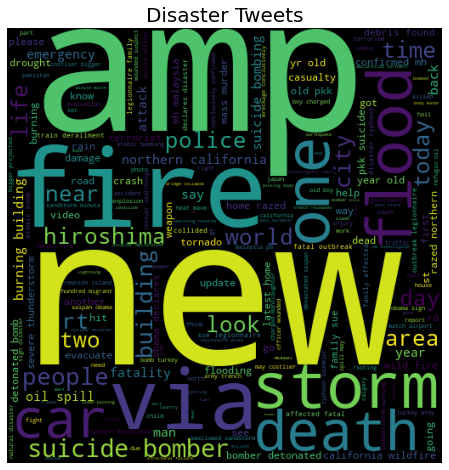

In [15]:
wordcloud(data_disaster,"Disaster Tweets")

 
now let's have a look on Non-Disaster tweets

## 4.3 Visualising words inside Fake Disaster Tweets

love,new,time etc are the most common words in wordcloud of Non-disaster tweets

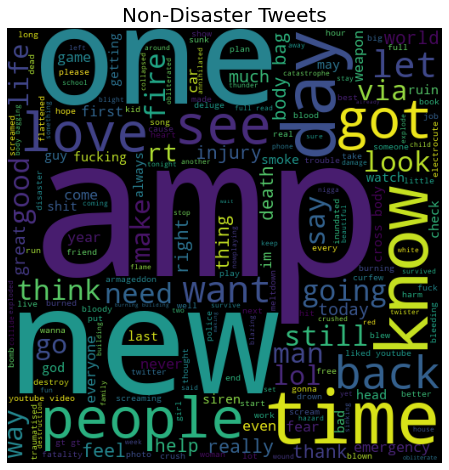

In [16]:
wordcloud(data_non_disaster,"Non-Disaster Tweets")

## 4.4 Removing unwanted words with high frequency

Our cleaned text still contains some unnecessary words (such as: like, amp, get, would etc.) that aren't relevant and can confuse our model,    
resulting in false prediction. Now, we will further remove some words with high frequency from text based on above charts.

In [17]:
common_words = ['via','like','build','get','would','one','two','feel',
                'lol','fuck','take','way','may','first','latest','want',
                'make','back','see','know','let','look','come','got',
                'still','say','think','great','pleas','amp']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

data["Cleaned_text"] = data["Cleaned_text"].apply(text_cleaning)

## 4.5 Analysing top 10 N-grams where N is 1,2,3

### What do you mean by N-grams?  
N-grams of texts are extensively used in text mining and natural language processing tasks.     They are basically a set of co-occurring words within a given window and when computing the n-grams you typically move one word forward (although you can move X words forward in more advanced scenarios).  

For example, for the sentence “The cow jumps over the moon”.    
If N=2 (known as bigrams), then the ngrams would be:  
* the cow 
* cow jumps 
* jumps over 
* over the 
* the moon

Below we perform [N-grams](https://en.wikipedia.org/wiki/N-gram#:~:text=In%20the%20fields%20of%20computational,a%20text%20or%20speech%20corpus.) analysis on cleaned data

In [18]:
def top_ngrams(data,n,grams):
    count_vec = CountVectorizer(ngram_range=(grams,grams)).fit(data)
    bow = count_vec.transform(data)
    add_words = bow.sum(axis=0)
    word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True) 
    return word_freq[:n]

Creating data of top 10 n-grams for n = 1, 2, 3

In [19]:
common_uni = top_ngrams(data["Cleaned_text"],10,1)
common_bi = top_ngrams(data["Cleaned_text"],10,2)
common_tri = top_ngrams(data["Cleaned_text"],10,3)
common_uni_df = pd.DataFrame(common_uni,columns=['word','freq'])
common_bi_df = pd.DataFrame(common_bi,columns=['word','freq'])
common_tri_df = pd.DataFrame(common_tri,columns=['word','freq'])

## 4.6 Visualising top 10 N-grams for N = 1, 2, 3

In [20]:
fig = make_subplots(rows=3, cols=1,subplot_titles=("Top 20 Unigrams in Text",
                    "Top 20 Bigrams in Text","Top 20 Trigrams in Text"))
  
fig.add_trace(
    
    go.Bar(x=common_uni_df["word"],y=common_uni_df["freq"],
           marker=dict(color= 'rgba(255, 170, 59,0.8)'),
           marker_line=dict(color='black'),marker_line_width=1.2),
           row=1, col=1

).add_trace(
    
    go.Bar(x=common_bi_df["word"],y=common_bi_df["freq"],
           marker=dict(color= 'rgba(89, 255, 147,0.8)'),
           marker_line=dict(color='black'),marker_line_width=1.2),
           row=2, col=1

).add_trace(
    
    go.Bar(x=common_tri_df["word"],y=common_tri_df["freq"],
           marker=dict(color= 'rgba(89, 153, 255,0.8)'),
           marker_line=dict(color='black'),marker_line_width=1.2),
           row=3, col=1
    
).update_layout(title_text="Visualization of Top 20 Unigrams, Bigrams and Trigrams",
                title_x=0.5,showlegend=False,
                width=800,height=1600,).update_xaxes(tickangle=-90).show()

# py.plot(fig,filename='Visualization of Top 20 Unigrams, Bigrams and Trigrams',auto_open=False,show_link=False)

<div>
    <a href="https://plotly.com/~raklugrin01/17/?share_key=rHBUmASeWITErHR7rEdZqJ" target="_blank" title="Visualization of Top 20 Unigrams, Bigrams and Trigrams" style="display: block; text-align: center;"><img src="https://plotly.com/~raklugrin01/17.png?share_key=rHBUmASeWITErHR7rEdZqJ" alt="Visualization of Top 20 Unigrams, Bigrams and Trigrams" style="max-width: 100%;width: 1400px;"  width="1400" onerror="this.onerror=null;this.src='https://plotly.com/404.png';" /></a>
    <script data-plotly="raklugrin01:17" sharekey-plotly="rHBUmASeWITErHR7rEdZqJ" src="https://plotly.com/embed.js" async></script>
</div>


# 5. Data Preprocessing and Creating Word Embedding Matrix

## 5.1 Spliting original data after cleaning 

In [21]:
#original data after cleaning 
X_inp_clean = data['Cleaned_text']
X_inp_original = data['text']
y_inp = data['target']

## 5.2 Data preprocessing and creating padded sentences

### What is Tokenization  

Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units,  
such as individual words or terms. Each of these smaller units are called tokens.  

The tokens could be words, numbers or punctuation marks. In tokenization, smaller units are created by  
locating word boundaries, which are the ending point of a word and the beginning of the next word. 

Now we use [keras](https://www.tensorflow.org/api_docs/python/tf/keras) text preprocessing [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to fit on text on Cleaned data

In [22]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_inp_clean.values)
vocab_length = len(word_tokenizer.word_index) + 1

Creating padded sentences using [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) function

In [23]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(X_inp_clean.values, key=lambda sentence: len(word_tokenize(sentence)))

length_long_sentence = len(word_tokenize(longest_train))

padded_sentences = pad_sequences(embed(X_inp_clean.values), 
                                 length_long_sentence, padding='post')

## 5.2 Using Glove word embeddings for creating Embedding Matrix

### Why Glove?

The advantage of GloVe is that, unlike Word2vec, GloVe does not rely just on local statistics (local context information of words),   
but incorporates global statistics (word co-occurrence) to obtain word vectors

Creating Embedding dictionary using [Glove Twitter data](https://www.kaggle.com/danielwillgeorge/glove6b100dtxt)

In [24]:
embeddings_dictionary = dict()

embedding_dim = 100

glove_file = open('../input/glove6b100dtxt/glove.6B.100d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

Creating Word Embedding matrix which is a list of all words and their corresponding embeddings.

In [25]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    
    embedding_vector = embeddings_dictionary.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## 5.3 Spliting data into training and validation dataset

Using [scikit-learn's train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the data into training and validation dataset

In [26]:
X_train, X_val, y_train, y_val = train_test_split(padded_sentences,
                                                  y_inp.values,test_size=0.2,random_state=1)

# 6. Training and Tuning Deep Learning Models

Function to summarise history of train our model

In [27]:
def model_history(model_history):
    fig,(ax1,ax2) =  plt.subplots(1,2,figsize=(12,5))
    
    # summarize history for accuracy
    ax1.plot(model_history.history['accuracy'])
    ax1.plot(model_history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper right')

    # summarize history for loss
    ax2.plot(model_history.history['loss'])
    ax2.plot(model_history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper right')
    
    fig.suptitle("Model History")
    

## 6.1 Training and Tuning Convolutional Neural Network

### What is a CNN?  
CNNs are basically just several layers of convolutions with nonlinear activation functions like ReLU or tanh applied to the results.     
In a traditional feedforward neural network we connect each input neuron to each output neuron in the next layer.    
That’s also called a fully connected layer, or affine layer. In CNNs we don’t do that. Instead, we use convolutions over the input layer to compute the output.   
This results in local connections, where each region of the input is connected to a neuron in the output. Each layer applies different filters,   
typically hundreds or thousands like the ones showed above, and combines their results.

Function for creating [Convolutional Neural Network](https://www.tensorflow.org/tutorials/images/cnn)

In [28]:
def CNN(hp):
    
    model = keras.Sequential()
    
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-2, 3e-3, 3e-4, 3e-5])
    
    model.add(Embedding(vocab_length, 100, weights=[embedding_matrix],
                                     input_length=length_long_sentence,trainable=False))
    
    model.add(Conv1D(filters=hp.Int('conv_1_filter',min_value=21,max_value=200,step=14),
                                kernel_size=hp.Choice('conv_1_kernel',values=[3,4,5]),
                                activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(MaxPooling1D(pool_size=2))
  
    model.add(Flatten())

    model.add(Dense(units = hp.Int('dense_1',min_value=21,max_value=150,step=14),
                                   activation='relu'))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(1,activation='sigmoid'))
  
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
    return model

Creating a tuner using Keras-Tuner(kt) for above function

In [29]:
tuner_CNN = kt.Hyperband(CNN,objective='val_accuracy',
                         max_epochs=15,factor=5,
                         directory='my_dir',
                         project_name='DisasterTweets_kt',
                         overwrite=True)

Searching for a model with highest accuracy and saving it's [hyperparameters](https://deepai.org/machine-learning-glossary-and-terms/hyperparameter)

In [30]:
stop_early = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=10)

tuner_CNN.search(X_train, y_train, epochs=15,
                 validation_data=(X_val,y_val),callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_CNN=tuner_CNN.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 00m 09s]
val_accuracy: 0.8049901723861694

Best val_accuracy So Far: 0.8049901723861694
Total elapsed time: 00h 01m 22s


Creating a model using the best hyperparameters and training it using [callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) to save  the model at appropriate [epoch](https://radiopaedia.org/articles/epoch-machine-learning)

In [31]:
model_CNN = tuner_CNN.hypermodel.build(best_hps_CNN)

checkpoint = ModelCheckpoint(
    'model_CNN.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

history_CNN = model_CNN.fit(X_train, y_train,epochs=50,
                            validation_data=(X_val,y_val),
                            callbacks=[checkpoint,stop_early])

Epoch 1/50
191/191 [==============================] - 2s 6ms/step - loss: 0.5657 - accuracy: 0.7100 - val_loss: 0.4635 - val_accuracy: 0.7945

Epoch 00001: val_loss improved from inf to 0.46351, saving model to model_CNN.h5
Epoch 2/50
191/191 [==============================] - 1s 5ms/step - loss: 0.4212 - accuracy: 0.8125 - val_loss: 0.4672 - val_accuracy: 0.7833

Epoch 00002: val_loss did not improve from 0.46351
Epoch 3/50
191/191 [==============================] - 1s 4ms/step - loss: 0.3900 - accuracy: 0.8281 - val_loss: 0.4582 - val_accuracy: 0.7984

Epoch 00003: val_loss improved from 0.46351 to 0.45822, saving model to model_CNN.h5
Epoch 4/50
191/191 [==============================] - 1s 4ms/step - loss: 0.3389 - accuracy: 0.8519 - val_loss: 0.5009 - val_accuracy: 0.7807

Epoch 00004: val_loss did not improve from 0.45822
Epoch 5/50
191/191 [==============================] - 1s 4ms/step - loss: 0.2959 - accuracy: 0.8659 - val_loss: 0.5139 - val_accuracy: 0.7846

Epoch 00005: val_

printing model's [summary](https://www.ibm.com/docs/SSLVMB_24.0.0/spss/tutorials/curveest_modelsummary_virus.html#:~:text=The%20model%20summary%20table%20reports,values%20of%20the%20dependent%20variable.)

In [32]:
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 100)           1484400   
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 77)            23177     
_________________________________________________________________
dropout (Dropout)            (None, 21, 77)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 77)            0         
_________________________________________________________________
flatten (Flatten)            (None, 770)               0         
_________________________________________________________________
dense (Dense)                (None, 133)               102543    
_________________________________________________________________
dropout_1 (Dropout)          (None, 133)               0

Ploting model's training and validation history

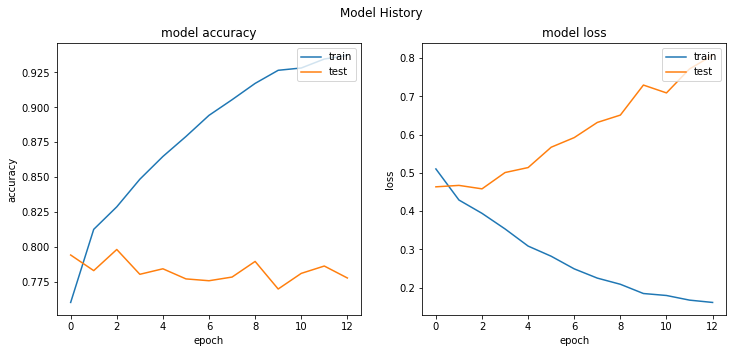

In [33]:
model_history(history_CNN)

## 6.2 Training and Tuning Multi-Channel Convolutional Neural Network

### Why Mulichannel CNN?   

A multi-channel convolutional neural network for document classification involves using multiple versions of the standard model with different sized kernels.   
This allows the document to be processed at different resolutions or different n-grams (groups of words) at a time, whilst the model learns how to best integrate these interpretations.

Function for creating [Multichannel CNN](https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/)

In [34]:
def MultichannelCNN(hp): 
    
    inputs1 = Input(shape=(length_long_sentence,))
    
    embedding1 = Embedding(vocab_length, 100, weights=[embedding_matrix],
                           input_length=length_long_sentence, trainable=False)(inputs1) 
    
    conv1 = Conv1D(filters=hp.Int('conv_1_filter',min_value=21,max_value=150,step=14),
                                kernel_size=hp.Choice('conv_1_kernel',values=[3,4,5,6,7,8]),
                                activation='relu')(embedding1) 
    
    drop1 = Dropout(0.3)(conv1) 
    
    pool1 = MaxPooling1D()(drop1) 
    
    flat1 = Flatten()(pool1)
    
    inputs2 = Input(shape=(length_long_sentence,)) 
    
    embedding2 = Embedding(vocab_length, 100, weights=[embedding_matrix],
                           input_length=length_long_sentence,trainable=False)(inputs2) 
    
    conv2 = Conv1D(filters=hp.Int('conv_2_filter',min_value=21,max_value=150,step=14),
                                kernel_size=hp.Choice('conv_2_kernel',values=[3,4,5,6,7,8]),
                                activation='relu')(embedding2) 
    
    drop2 = Dropout(0.3)(conv2) 
    
    pool2 = MaxPooling1D()(drop2) 
    
    flat2 = Flatten()(pool2) 
    
    # merge 
    merged = concatenate([flat1, flat2]) 
    
    dense1 = Dense(units = hp.Int('dense_1',min_value=21,max_value=120,step=14),
                               activation='relu')(merged)
    
    drop4 = Dropout(0.5)(dense1)
    
    outputs = Dense(1, activation='sigmoid')(drop4) 
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs) 
    
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-2, 3e-3, 3e-4, 3e-5]) 
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
    return model

Creating a tuner using Keras-Tuner(kt) for above function, searching for best hyperparameters

In [35]:
tuner_MCNN = kt.Hyperband(MultichannelCNN,objective='val_accuracy',
                          max_epochs=15,factor=5,
                          directory='my_dir',
                          project_name='DisasterTweetsMCNN_kt',
                          overwrite=True)

stop_early = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=10)

tuner_MCNN.search([X_train,X_train], y_train, epochs=15,
                  validation_data=([X_val,X_val], y_val),
                  callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_MCNN=tuner_MCNN.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 00m 15s]
val_accuracy: 0.803676962852478

Best val_accuracy So Far: 0.803676962852478
Total elapsed time: 00h 01m 41s


Creating a model for best found hyperparameters and training it

In [36]:
model_MCNN = tuner_MCNN.hypermodel.build(best_hps_MCNN)

checkpoint = ModelCheckpoint(
    'model_MCNN.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

history_MCNN = model_MCNN.fit([X_train,X_train], y_train,epochs=50,
                              validation_data=([X_val,X_val], y_val),
                              callbacks=[checkpoint,stop_early])

Epoch 1/50
191/191 [==============================] - 2s 6ms/step - loss: 0.6103 - accuracy: 0.6720 - val_loss: 0.4788 - val_accuracy: 0.7840

Epoch 00001: val_loss improved from inf to 0.47883, saving model to model_MCNN.h5
Epoch 2/50
191/191 [==============================] - 1s 5ms/step - loss: 0.4568 - accuracy: 0.7973 - val_loss: 0.4590 - val_accuracy: 0.7925

Epoch 00002: val_loss improved from 0.47883 to 0.45901, saving model to model_MCNN.h5
Epoch 3/50
191/191 [==============================] - 1s 5ms/step - loss: 0.4316 - accuracy: 0.8065 - val_loss: 0.4533 - val_accuracy: 0.7971

Epoch 00003: val_loss improved from 0.45901 to 0.45332, saving model to model_MCNN.h5
Epoch 4/50
191/191 [==============================] - 1s 5ms/step - loss: 0.3837 - accuracy: 0.8267 - val_loss: 0.4581 - val_accuracy: 0.7945

Epoch 00004: val_loss did not improve from 0.45332
Epoch 5/50
191/191 [==============================] - 1s 5ms/step - loss: 0.3420 - accuracy: 0.8490 - val_loss: 0.4644 - va

ploting model's summary

In [37]:
model_MCNN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 23, 100)      1484400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 23, 100)      1484400     input_2[0][0]                    
______________________________________________________________________________________________

ploting model training and validating history

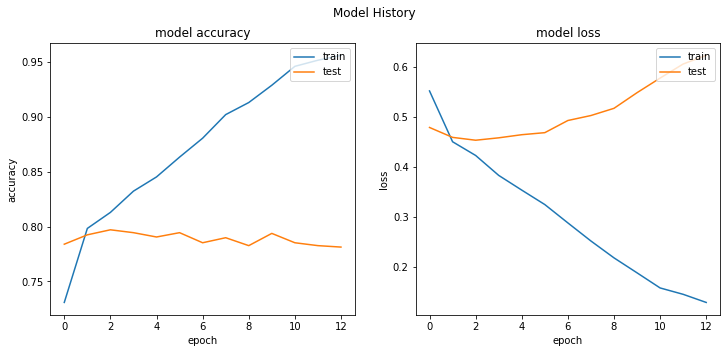

In [38]:
model_history(history_MCNN)

## 6.3 Training and Tuning Bidirectinal Long Short-Term Memory (LSTM) networks

### What are Bidirectional-LSTM networks?  

Bidirectional recurrent neural networks(RNN) are really just putting two independent RNNs together.   
This structure allows the networks to have both backward and forward information about the sequence at every time step
   
Using bidirectional will run your inputs in two ways, one from past to future and one from future to past and what differs 
this approach   
from unidirectional is that in the LSTM that runs backward you preserve information from the future and using the two hidden states combined  
you are able in any point in time to preserve information from both past and future.

Function for creating [Bidirectional Long Short-Term Memory](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/#:~:text=Bidirectional%20LSTMs%20are%20an%20extension,LSTMs%20on%20the%20input%20sequence.) (LSTM) networks

In [39]:
def BiLSTM(hp):
    model = Sequential()
    
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence,trainable = False))
    
    model.add(Bidirectional(CuDNNLSTM(units = hp.Int('dense_1',
                                      min_value=21,max_value=120,step=14)
                                      ,return_sequences = True)))
    
    model.add(GlobalMaxPool1D())
   
    model.add(BatchNormalization())
    
    model.add(Dropout(0.2))
    
    model.add(Dense(units = hp.Int('dense_1',min_value=21,
                                   max_value=120,step=14),
                    activation = "relu"))
    
    model.add(Dropout(0.3))
    
    model.add(Dense(units = hp.Int('dense_1',min_value=21,
                                   max_value=100,step=14),
                    activation = "relu"))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation = 'sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', 
                                 values=[3e-2, 3e-3, 3e-4, 3e-5]) 
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
    return model

Creating a tuner using Keras-Tuner(kt) for above function, searching for best hyperparameters

In [40]:
tuner_BiLSTM = kt.Hyperband(BiLSTM,objective='val_accuracy',
                     max_epochs=15,factor=5,
                     directory='my_dir',
                     project_name='DisasterTweetsBiLSTM_kt',
                     overwrite=True)

stop_early = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=12)

tuner_BiLSTM.search(X_train, y_train, epochs=15,
                    validation_data=(X_val, y_val),
                    callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_BiLSTM=tuner_BiLSTM.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 00m 26s]
val_accuracy: 0.7931713461875916

Best val_accuracy So Far: 0.8200919032096863
Total elapsed time: 00h 02m 52s


Creating a model for best found hyperparameters and training it

In [41]:
model_BiLSTM = tuner_BiLSTM.hypermodel.build(best_hps_BiLSTM)

checkpoint = ModelCheckpoint(
    'model_BiLSTM.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

history_BiLSTM = model_BiLSTM.fit(X_train, y_train, epochs=50,
                                  validation_data=(X_val, y_val),
                                  callbacks=[checkpoint,stop_early])

Epoch 1/50
191/191 [==============================] - 3s 9ms/step - loss: 0.5806 - accuracy: 0.7247 - val_loss: 0.5917 - val_accuracy: 0.7262

Epoch 00001: val_loss improved from inf to 0.59175, saving model to model_BiLSTM.h5
Epoch 2/50
191/191 [==============================] - 1s 7ms/step - loss: 0.4398 - accuracy: 0.8056 - val_loss: 0.4776 - val_accuracy: 0.8096

Epoch 00002: val_loss improved from 0.59175 to 0.47757, saving model to model_BiLSTM.h5
Epoch 3/50
191/191 [==============================] - 1s 7ms/step - loss: 0.4271 - accuracy: 0.8220 - val_loss: 0.4336 - val_accuracy: 0.8148

Epoch 00003: val_loss improved from 0.47757 to 0.43355, saving model to model_BiLSTM.h5
Epoch 4/50
191/191 [==============================] - 2s 8ms/step - loss: 0.3922 - accuracy: 0.8306 - val_loss: 0.4432 - val_accuracy: 0.8096

Epoch 00004: val_loss did not improve from 0.43355
Epoch 5/50
191/191 [==============================] - 1s 7ms/step - loss: 0.3700 - accuracy: 0.8396 - val_loss: 0.490

printing model's summary

In [42]:
model_BiLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 100)           1484400   
_________________________________________________________________
bidirectional (Bidirectional (None, 23, 154)           110264    
_________________________________________________________________
global_max_pooling1d (Global (None, 154)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 154)               616       
_________________________________________________________________
dropout (Dropout)            (None, 154)               0         
_________________________________________________________________
dense (Dense)                (None, 77)                11935     
_________________________________________________________________
dropout_1 (Dropout)          (None, 77)                0

ploting training and validation history of the model

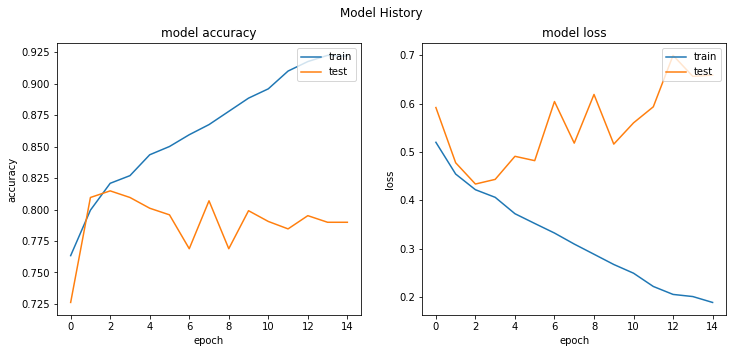

In [43]:
model_history(history_BiLSTM)

## 6.4 Training DistilBert transformer

Using scikit-learn's [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to [one hot encode](https://www.sciencedirect.com/topics/computer-science/one-hot-encoding) the target column   
and spliting the data into training and validation set.

In [44]:
onehot_encoder = OneHotEncoder(sparse=False)

y = (np.asarray(y_inp)).reshape(-1,1)

Y = onehot_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X_inp_clean,Y,
                                                  test_size=0.2, random_state=1)

### What is DistilBert?
DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased ,    
runs 60% faster while preserving over 95% of BERT's performances as measured on the GLUE language understanding benchmark.

Creating model checkpoint for [DistilBert](https://huggingface.co/distilbert-base-uncased) model and importing it's pretrained AutoTokenizer

In [45]:
model_checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

An example of how tokenizer works

In [46]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [101, 7592, 1010, 2023, 2028, 6251, 999, 102, 1998, 2023, 6251, 3632, 2007, 2009, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

[Tokenizing](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html) training and validation data

In [47]:
def regular_encode(texts, tokenizer, maxlen=512):
    
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen,
        add_special_tokens = True,
        truncation=True
    )
    
    return np.array(enc_di['input_ids'])

X_train_t = regular_encode(list(X_train), tokenizer, maxlen=512)

X_val_t = regular_encode(list(X_val), tokenizer, maxlen=512)

Creating train and validation dataset with [batch size](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) 16

In [48]:
AUTO = tf.data.experimental.AUTOTUNE

batch_size = 16

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train_t, y_train))
    .repeat()
    .shuffle(1995)
    .batch(batch_size)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val_t, y_val))
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

Function that will return our model

In [49]:
def build_model(transformer, max_len=512):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32,
                           name="input_word_ids")
    
    sequence_output = transformer(input_word_ids)[0]
    
    cls_token = sequence_output[:, 0, :]
    
    out = Dense(2, activation='softmax')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Building the Model

In [50]:
transformer_layer = TFAutoModel.from_pretrained(model_checkpoint)

model_DistilBert = build_model(transformer_layer)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['classifier', 'pre_classifier', 'dropout_19']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


printing model's summary

In [51]:
model_DistilBert.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1538      
Total params: 66,364,418
Trainable params: 66,364,418
Non-trainable params: 0
_________________________________________________________________


Training the model

In [52]:
n_steps = X_train.shape[0] // batch_size

history_DistilBert = model_DistilBert.fit(train_dataset,
                                          steps_per_epoch=n_steps,
                                          validation_data=valid_dataset,
                                          epochs=3)

Epoch 1/3
380/380 [==============================] - 225s 572ms/step - loss: 0.5989 - accuracy: 0.6687 - val_loss: 0.4158 - val_accuracy: 0.8194
Epoch 2/3
380/380 [==============================] - 216s 569ms/step - loss: 0.4050 - accuracy: 0.8234 - val_loss: 0.4449 - val_accuracy: 0.8148
Epoch 3/3
380/380 [==============================] - 216s 569ms/step - loss: 0.3461 - accuracy: 0.8531 - val_loss: 0.4439 - val_accuracy: 0.8102


ploting model's training and validation history

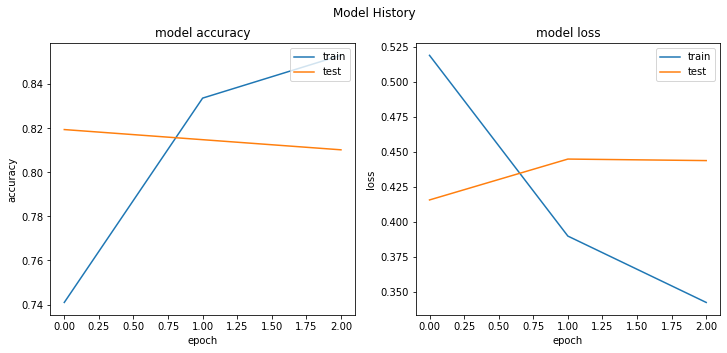

In [53]:
model_history(history_DistilBert)